# Product Recommendation System Based on Sentiment Analysis

In this era of information explosion, Recommender syytems gain more popularity as they can make appropriate and personalized recommendations for users based on users past purchases and profiles. There are many different types of algorithms used for recommendation sysytems. In this project I will be exploring popularity based recommendation systems based on ratings and polarity, content based recommendation and Collaborative recommendation based on polarity.

The data is already cleaned and preprocessed in a separate notebook. There are many NLP techniques to find the polarity of the text. The polarity if the review is found using Textblob in a separate notebook.

In [6]:
#Import necessary libraries
import pandas as pd
import numpy as np
import time
import random

from PIL import Image 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import calendar
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
   
import regex as re


from sklearn.metrics import classification_report, confusion_matrix


from sklearn.metrics import plot_confusion_matrix

import nltk
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rudharapathipandiyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
#Read the csv
reviews=pd.read_csv('reviews_preprocessed_final.csv',dtype='unicode',usecols = ['reviewerID','product_id','ratings','reviewcomb','ratings','title','description','clean_description','year','polarity'])

In [92]:
reviews_read = reviews.copy()

In [93]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462437 entries, 0 to 462436
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   reviewerID         462437 non-null  object
 1   product_id         462437 non-null  object
 2   ratings            462437 non-null  object
 3   title              462437 non-null  object
 4   description        462437 non-null  object
 5   year               462437 non-null  object
 6   reviewcomb         462437 non-null  object
 7   clean_description  462437 non-null  object
 8   polarity           462437 non-null  object
dtypes: object(9)
memory usage: 31.8+ MB


In [94]:
reviews.isnull().sum()

reviewerID           0
product_id           0
ratings              0
title                0
description          0
year                 0
reviewcomb           0
clean_description    0
polarity             0
dtype: int64

In [95]:
reviews.dropna(inplace=True)

In [96]:
#Convert the columns into appropriate datatype
reviews["ratings"] = reviews.ratings.astype(int)
reviews["year"] = reviews.year.astype(int)
reviews["polarity"] = reviews.polarity.astype(float)

In [97]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462437 entries, 0 to 462436
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   reviewerID         462437 non-null  object 
 1   product_id         462437 non-null  object 
 2   ratings            462437 non-null  int64  
 3   title              462437 non-null  object 
 4   description        462437 non-null  object 
 5   year               462437 non-null  int64  
 6   reviewcomb         462437 non-null  object 
 7   clean_description  462437 non-null  object 
 8   polarity           462437 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 35.3+ MB


In [98]:
pd.set_option('display.max_colwidth', None)
reviews.head(1)['description']

0    ['Marvis Jasmin Mint offers a sweet and cool touch of mint with the surprising charm of the floral note of jasmin. Marvis flavors are created by offsetting the aroma of mint, to provide the freshness you need, with innovative notes to offer you a long-lasting pleasurable taste sensation that can be different every day. Marvis is a luxury line of oral care products that turn your daily teeth cleaning ritual into a wonderful sensory experience. Our gentle xylitol- and sorbitan-based formulas cleanse and condition your teeth and gums without causing irritation.', 'By Marvis', '', '<img alt="" src="https://m.media-amazon.com/images/S/aplus-media/vc/a6ee37b8-8520-468e-8999-4cdb4825b4ce._SL220__.jpg">', '<img alt="" src="https://m.media-amazon.com/images/S/aplus-media/vc/8ab0d41b-dbd4-48ac-84e7-1815d65028df._SL220__.jpg">', '<img alt="" src="https://m.media-amazon.com/images/S/aplus-media/vc/1091a036-acfb-440a-a2e6-1e77c9a1166d._SL220__.jpg">', '<img alt="" src="https://m.media-amazon.c

In [99]:
#Check number of reviews
len(reviews)

462437

In [100]:
unique_users = reviews.groupby(['reviewerID', 'title']).size().groupby('reviewerID').size()
print('Number of unique users',len(unique_users))

Number of unique users 376680


In [101]:
# Filter reviewers with more that 5 purchases
top_users = unique_users[unique_users>=5].reset_index()['reviewerID']
len(top_users)

3141

In [102]:
#Number of purchases from top users
top_user_reviews = reviews.merge(top_users, on = 'reviewerID', how = 'right')
len(top_user_reviews)

27359

In [103]:
#Check unique products in the dataset
unique_products =reviews['product_id'].unique()
len(reviews['product_id'].unique())

11600

In [104]:
# reviews = top_user_reviews.copy()

In [105]:
# reviews.drop_duplicates(subset = ['title'], inplace=True)

In [106]:
reviews.shape

(462437, 9)

# Popularity based Recommender

Popularity based recommender model works with the latest trend. It just uses the products which are in trend right now. For example, a product which was bought the most will be recommended to a new user who have just signed up.Popular products can be popped up by counting the total number of ratings for each product.

In [25]:
#Recommendation based on rating counts
products_ratingcount = reviews.groupby('title')['ratings'].count().sort_values(ascending=False).reset_index()
products_ratingcount.head(10)

,title,ratings
0,HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,4441
1,TOPPIK Hair Building Fibers,3184
2,"Mario Badescu Facial Spray with Aloe, Herbs and Rosewater, 8 oz.",2919
3,MERKUR Classic 3-Piece Razor Double Edge Saftey Razor,2891
4,"OPI Nail Lacquer, Cajun Shrimp, 0.5 fl. oz.",2794
5,BaBylissPRO Ceramix Xtreme Dryer,2644
6,OPI Nail Envy Nail Strengthener,2596
7,"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",2561
8,"Proraso Shaving Soap in a Bowl, Refreshing and Toning, 5.2 oz",2440
9,stila Stay All Day Waterproof Liquid Eye Liner,2392


In [26]:
most_rated_products = products_ratingcount.rename(columns = {'ratings':'ratingcount'})
most_rated_products_summary = pd.merge(most_rated_products,reviews, on ='title')
most_rated_products_summary

,title,ratingcount,reviewerID,product_id,ratings,description,year,reviewcomb,clean_description,polarity
0,HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,4441,A25TMCRT4TAKBY,B000FIFH46,5,"['Hot Tools HT1138 Micro Mini Professional Curling Iron with Multi Heat Control, 3/8 Inches', 'Hot Tools Professional is a reliable brand thats been winning awards for over 25 years, creating superior, stylist preferred styling tools that consist of innovation in every way.', '<span class=""a-text-bold"">Hot Tools Professional is a dependable brand, creating superior, stylist preferred styling tools that are innovative in every way.</span>', '<span class=""a-text-bold"">Whether it be in the materials, appliance features or ergonomic designs, Hot Tools helps individuals own the day with tools that deliver beautiful, long-lasting hairstyles.</span>', '<span class=""a-text-bold"">Add some sparkle to your styling with a 24K Gold Surface. Its your ticket to gorgeous hair. Create all kinds of beautiful curls.</span>', '<span class=""a-text-bold"">The possibilities are endless: super tight, defined or bouncy curls. Or maybe you prefer romantic, tousled curls. Or, what about loose curls or waves? Whichever style you are after, you will achieve it with this cutting-edge technology. Its the gold standard.</span>']",2010,"This tool is way fun to use. Like all the other ""Hot Tools"" I own, it works wonderfully. It heats up fast and works like a charm on all different type textured hair. I have curly hair and i use this tool to define my already tight curls. But all my other friends have thick straight hair, and they love how this tool makes their hair curl so fast and easily. I would recommend this iron to any one who is looking for a reliable tool that makes tight curls. And amazon had the best price. Hot Tools 3/8 inch",hot tool ht micro mini profession curl iron multi heat control inch hot tool profession reliabl brand that win award year creat superior stylist prefer style tool consist innov everi way hot tool profession depend brand creat superior stylist prefer style tool innov everi way whether materi applianc featur ergonom design hot tool help individu day tool deliv beauti long last hairstyl add sparkl style k gold surfac ticket gorgeous hair creat kind beauti curl possibl endless super tight defin bounci curl mayb prefer romant tousl curl loos curl wave whichev style achiev cut edg technolog gold standard,0.236835
1,HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,4441,A1HCNBBHD9T996,B000FIFH46,5,"['Hot Tools HT1138 Micro Mini Professional Curling Iron with Multi Heat Control, 3/8 Inches', 'Hot Tools Professional is a reliable brand thats been winning awards for over 25 years, creating superior, stylist preferred styling tools that consist of innovation in every way.', '<span class=""a-text-bold"">Hot Tools Professional is a dependable brand, creating superior, stylist preferred styling tools that are innovative in every way.</span>', '<span class=""a-text-bold"">Whether it be in the materials, appliance features or ergonomic designs, Hot Tools helps individuals own the day with tools that deliver beautiful, long-lasting hairstyles.</span>', '<span class=""a-text-bold"">Add some sparkle to your styling with a 24K Gold Surface. Its your ticket to gorgeous hair. Create all kinds of beautiful curls.</span>', '<span class=""a-text-bold"">The possibilities are endless: super tight, defined or bouncy curls. Or maybe you prefer romantic, tousled curls. Or, what about loose curls or waves? Whichever style you are after, you will achieve it with this cutting-edge technology. Its the gold standard.</span>']",2009,"Love this product...I use it twice a month for my daughter's hair for gymnastic meets. It is extremely hot like the product says, so, I use Got2b Guardian Angel Heat Protectant before curling. The temperature does not diminish while using, and the curls a

Some of the products might have high number of rtaings but the average rating will be low and we cannot recommend products with low average rating. Therefore average rating of products will be good measure to find popular products in addition to total ratings count. Let us find the average rating of our popular products.

In [27]:
avg_rating = pd.DataFrame(reviews.groupby('title')['ratings'].mean())
avg_rating['ratingcount'] = pd.DataFrame(reviews.groupby('title')['ratings'].count())


In [28]:
avg_rating.sort_values('ratingcount', ascending = False).head(10)

,ratings,ratingcount
title,,
HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,4.118442,4441
TOPPIK Hair Building Fibers,4.081030,3184
"Mario Badescu Facial Spray with Aloe, Herbs and Rosewater, 8 oz.",4.355944,2919
MERKUR Classic 3-Piece Razor Double Edge Saftey Razor,4.494639,2891
"OPI Nail Lacquer, Cajun Shrimp, 0.5 fl. oz.",4.188976,2794
BaBylissPRO Ceramix Xtreme Dryer,4.195915,2644
OPI Nail Envy Nail Strengthener,4.315871,2596
"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",3.946505,2561
"Proraso Shaving Soap in a Bowl, Refreshing and Toning, 5.2 oz",4.592213,2440


For our dataset, high rating count products has also got good average ratings which might not be the case at all times. Therefore these products could be recommended to any new user signing up.

Text(0, 0.5, 'Number of Reviews')

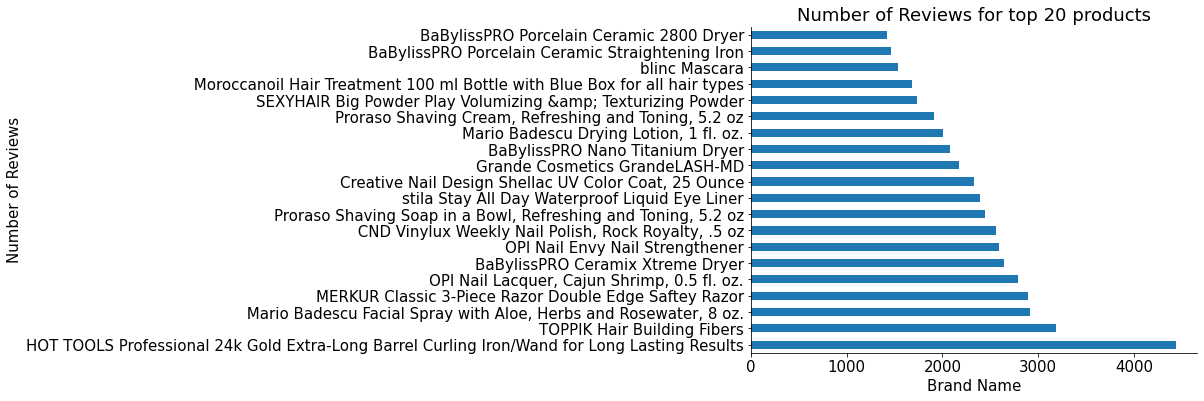

In [69]:
#Plot the top 20 popular products
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 15
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


products = reviews["title"].value_counts()

products[:20].plot(kind='barh')
plt.title("Number of Reviews for top 20 products")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

In [ ]:
# #Class for Popularity based Recommender System model
# class popularity_recommender():
#     def __init__(self):
#         self.reviews = None
#         self.reviewerID = None
#         self.title = None
#         self.popularity_recommendations = None
        
#     #Create the popularity based recommender system model
#     def create(self, reviews, ratings, title):
#         self.ratings = ratings
#         self.title = title

#         #Count ratings and groupby products
#         reviews_grouped = reviews.groupby([self.title]).agg({self.ratings: 'count'}).reset_index()
#         reviews_grouped.rename(columns = {'ratings': 'total_ratings'},inplace=True)
    
#         #Sort the products based upon recommendation
#         reviews_sort = reviews_grouped.sort_values(['total_ratings', self.title], ascending = False)
    
#         #Get the top 10 recommendations
#         self.popularity_recommendations = reviews_sort.head(10)

#     #Use the popularity based recommender system model to make recommendations
#     def recommend(self, reviewerID):    
#         user_recommendations = self.popularity_recommendations
        
#         #Add reviewerID column for which the recommendations are being generated
#         user_recommendations['reviewerID'] = reviewerID
    
#         #Bring reviewerID column to the front
#         cols = user_recommendations.columns.tolist()
#         cols = cols[-1:] + cols[:-1]
#         user_recommendations = user_recommendations[cols]
        
#         return user_recommendations
    

In [81]:
#Class for Popularity based Recommender System model
class popularity_recommender():
    def __init__(self):
        self.reviews = None
        self.reviewerID = None
        self.title = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, reviews, reviewerID, title):
        self.reviewerID = reviewerID
        self.title = title

        #Count reviewerID and groupby products
        reviews_grouped = reviews.groupby([self.title]).agg({self.reviewerID: 'count'}).reset_index()
        reviews_grouped.rename(columns = {'reviewerID': 'ratings_count'},inplace=True)
    
        #Sort the products based upon recommendation
        reviews_sort = reviews_grouped.sort_values(['ratings_count', self.title], ascending = False)
    
        #Get the top 10 recommendations
        self.popularity_recommendations = reviews_sort.head(10)

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, reviewerID):    
        user_recommendations = self.popularity_recommendations
        
        #Add reviewerID column for which the recommendations are being generated
        user_recommendations['reviewerID'] = reviewerID
    
        #Bring reviewerID column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

I have created a popularity recommender class which can be used to recommend products to users based on ratings count. Create an instance of recommender class to make recommendations.

In [82]:
#Create instance of popularity_recomemnder class
pop_model = popularity_recommender()
pop_model.create(reviews, 'reviewerID', 'title')

In [83]:
#Give recommendations for user 0
reviewerID = top_users[0]
pop_model.recommend(reviewerID)

,reviewerID,title,ratings_count
3755,A0488385844WNV2OWO9X,HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,4441
9482,A0488385844WNV2OWO9X,TOPPIK Hair Building Fibers,3184
123,A0488385844WNV2OWO9X,"Mario Badescu Facial Spray with Aloe, Herbs and Rosewater, 8 oz.",2919
6017,A0488385844WNV2OWO9X,MERKUR Classic 3-Piece Razor Double Edge Saftey Razor,2891
7052,A0488385844WNV2OWO9X,"OPI Nail Lacquer, Cajun Shrimp, 0.5 fl. oz.",2794
1094,A0488385844WNV2OWO9X,BaBylissPRO Ceramix Xtreme Dryer,2644
7044,A0488385844WNV2OWO9X,OPI Nail Envy Nail Strengthener,2596
24,A0488385844WNV2OWO9X,"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",2561
7887,A0488385844WNV2OWO9X,"Proraso Shaving Soap in a Bowl, Refreshing and Toning, 5.2 oz",2440
11175,A0488385844WNV2OWO9X,stila Stay All Day Waterproof Liquid Eye Liner,2392


In [84]:
#Give recommendations for user 100
reviewerID = top_users[100]
pop_model.recommend(reviewerID)

,reviewerID,title,ratings_count
3755,A13Z4O01GOIYE2,HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,4441
9482,A13Z4O01GOIYE2,TOPPIK Hair Building Fibers,3184
123,A13Z4O01GOIYE2,"Mario Badescu Facial Spray with Aloe, Herbs and Rosewater, 8 oz.",2919
6017,A13Z4O01GOIYE2,MERKUR Classic 3-Piece Razor Double Edge Saftey Razor,2891
7052,A13Z4O01GOIYE2,"OPI Nail Lacquer, Cajun Shrimp, 0.5 fl. oz.",2794
1094,A13Z4O01GOIYE2,BaBylissPRO Ceramix Xtreme Dryer,2644
7044,A13Z4O01GOIYE2,OPI Nail Envy Nail Strengthener,2596
24,A13Z4O01GOIYE2,"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",2561
7887,A13Z4O01GOIYE2,"Proraso Shaving Soap in a Bowl, Refreshing and Toning, 5.2 oz",2440
11175,A13Z4O01GOIYE2,stila Stay All Day Waterproof Liquid Eye Liner,2392


Here we could see that same products are recommended for user 0 and user 100 as the products are recommended without any personalization. 

# Polarity Based Recommendation Model

The process of extracting opinions from textual reviews is called as sentiment analysis/opinion mining.If the polarity score of a review of product is greater than zero, then the review is the positively polarized; if it is less than zero, then it is negatively polarized; and if it is equal to zero, then it represents the neutrality.The NLTK library is used to identify the polarity of the textual reviews. In this recommendation sustem, I have aggregated the polarity of each product and provided recommendation.

In [87]:
#Class for Polarity based Recommender System model
class polarity__based_recommender():
    def __init__(self):
        self.reviews = None
        self.reviewerID = None
        self.title = None
        self.polarity__based_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, reviews, reviewerID, polarity, title):
        self.reviewerID = reviewerID
        self.title = title
        self.polarity = polarity

        #Aggregte polarity and groupby products
        reviews_grouped = reviews.groupby([self.title]).agg({self.polarity: 'sum'}).reset_index()
#         reviews_grouped.rename(columns = {'reviewerID': 'ratings_count'},inplace=True)
    
        #Sort the products based upon polarity recommendation
        reviews_sort = reviews_grouped.sort_values(['polarity', self.title], ascending = False)
    
        #Get the top 10 recommendations
        self.polarity__based_recommendations = reviews_sort.head(10)

    #Use the polarity based recommender system model to make recommendations
    def recommend(self, reviewerID):    
        user_recommendations = self.polarity__based_recommendations
        
        #Add reviewerID column for which the recommendations are being generated
        user_recommendations['reviewerID'] = reviewerID
    
        #Bring reviewerID column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

In [88]:
pol_model = polarity__based_recommender()
pol_model.create(reviews, 'reviewerID', 'polarity','title')

In [89]:
#Give recommendations for user 0
reviewerID = top_users[0]
pol_model.recommend(reviewerID)

,reviewerID,title,polarity
3755,A0488385844WNV2OWO9X,HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,1417.912747
123,A0488385844WNV2OWO9X,"Mario Badescu Facial Spray with Aloe, Herbs and Rosewater, 8 oz.",1047.631091
7052,A0488385844WNV2OWO9X,"OPI Nail Lacquer, Cajun Shrimp, 0.5 fl. oz.",989.357349
7887,A0488385844WNV2OWO9X,"Proraso Shaving Soap in a Bowl, Refreshing and Toning, 5.2 oz",950.815556
6017,A0488385844WNV2OWO9X,MERKUR Classic 3-Piece Razor Double Edge Saftey Razor,887.854510
2389,A0488385844WNV2OWO9X,"Creative Nail Design Shellac UV Color Coat, 25 Ounce",820.058092
9482,A0488385844WNV2OWO9X,TOPPIK Hair Building Fibers,803.625613
1094,A0488385844WNV2OWO9X,BaBylissPRO Ceramix Xtreme Dryer,731.950890
24,A0488385844WNV2OWO9X,"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",729.450665
7883,A0488385844WNV2OWO9X,"Proraso Shaving Cream, Refreshing and Toning, 5.2 oz",696.423854


In [90]:
#Give recommendations for user 0
reviewerID = top_users[100]
pol_model.recommend(reviewerID)

,reviewerID,title,polarity
3755,A13Z4O01GOIYE2,HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results,1417.912747
123,A13Z4O01GOIYE2,"Mario Badescu Facial Spray with Aloe, Herbs and Rosewater, 8 oz.",1047.631091
7052,A13Z4O01GOIYE2,"OPI Nail Lacquer, Cajun Shrimp, 0.5 fl. oz.",989.357349
7887,A13Z4O01GOIYE2,"Proraso Shaving Soap in a Bowl, Refreshing and Toning, 5.2 oz",950.815556
6017,A13Z4O01GOIYE2,MERKUR Classic 3-Piece Razor Double Edge Saftey Razor,887.854510
2389,A13Z4O01GOIYE2,"Creative Nail Design Shellac UV Color Coat, 25 Ounce",820.058092
9482,A13Z4O01GOIYE2,TOPPIK Hair Building Fibers,803.625613
1094,A13Z4O01GOIYE2,BaBylissPRO Ceramix Xtreme Dryer,731.950890
24,A13Z4O01GOIYE2,"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",729.450665
7883,A13Z4O01GOIYE2,"Proraso Shaving Cream, Refreshing and Toning, 5.2 oz",696.423854


We could see that the products recomemnded is slightly different from the populrity model as the recommendations here are based on user sentiment which is much more qualitative than just based on ratings. The reason for less reliabilty is the use of only quantitative data ratings which ignored the qualitative aspect of user feedback and challenge the reliability of the previous recommendations. The qualitative and quantitative aspects of likeness can be achieved by using not only ratings but also text reviews.

# Content based Recommendation system

Another popular recommendation technique if content - based filtering. Content refers to the content or attributes of the products we like. the main thing here is to tag products using certain keywords, understand what the user likes, find those keywords in the database and recommend different products with same attributes.

##  Tfidf with cosine similarity

The TF (term frequency) is the number of times a word appears in a document. The IDF (inverse document frequency) is the measure of how significant that word in the whole corpus. TF-IDF vectorizer calculates the TF-IDF score for each document’s description, word-by-word.Here, the tfidf_matrix is the matrix containing each word and its TF-IDF score with regard to each document, or product in our case. Also, stop words are simply words that add no significant value in our dataset, like ‘the’, ‘is’, ‘an’, and are therefore ignored.Now, we have a representation of every product in terms of its description. Next, we need to calculate the relevance or similarity of one product to another.

In [107]:
reviews.drop_duplicates(subset = ['title'], inplace=True)

In [108]:
tfidf = TfidfVectorizer(min_df = 3, max_features = None, analyzer ='word', token_pattern = r'\w{1,}',
                      stop_words = 'english',ngram_range = (1,2)) #reduce the ngram range to reduce computional complexity

In [109]:
reviews.shape

(11267, 9)

In [110]:
tfidf_matrix = tfidf.fit_transform(reviews['description'])

In [111]:
tfidf_matrix

<11267x67632 sparse matrix of type '<class 'numpy.float64'>'
	with 1165075 stored elements in Compressed Sparse Row format>

In [112]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [116]:
cosine_sim

array([[1.        , 0.02332124, 0.00261129, ..., 0.01109301, 0.        ,
        0.00146127],
       [0.02332124, 1.        , 0.        , ..., 0.0169123 , 0.01132715,
        0.        ],
       [0.00261129, 0.        , 1.        , ..., 0.008163  , 0.        ,
        0.        ],
       ...,
       [0.01109301, 0.0169123 , 0.008163  , ..., 1.        , 0.02674246,
        0.        ],
       [0.        , 0.01132715, 0.        , ..., 0.02674246, 1.        ,
        0.        ],
       [0.00146127, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [117]:
indices = pd.Series(reviews.index, index=reviews['title']).drop_duplicates()
indices

title
Marvis Jasmin Mint Toothpaste, 3.8 oz                                                                                                                                         0
stila Lip Glaze                                                                                                                                                             414
SESDERMA C-VIT- Crema Hidratante Facial Vitamina C + Ginkgo Biloba + Extracto naranja dulce | Anti Edad, Anti Manchas, Aclarante, Reafirmante, Nutre y Repara | 50 ml       495
The Art of Shaving Brush Stand Black                                                                                                                                        513
Baxter of California After Shave Balm, Cooling Sensation, 4 fl. oz.                                                                                                         667
                                                                                                                  

In [118]:
indices['Marvis Jasmin Mint Toothpaste, 3.8 oz']

0

In [114]:
#Function to give recommendations based on product attributes
def give_recommend(title):
    idx = indices[title] #get index corressponding to title
    cos_scores = list(enumerate(cosine_sim[idx])) #get similarity scores
    cos_scores = sorted(cos_scores,key=lambda x:x[1], reverse=True) #sort the products
    cos_scores =cos_scores[1:11] #scores for 10 similar products
    pd_indices = [i[0] for i in cos_scores] #product indices
    
    return reviews['title'].iloc[pd_indices] #return top 10 similar products

In [115]:
give_recommend('Marvis Jasmin Mint Toothpaste, 3.8 oz')

4212                                                         Marvis Classic Strong Mint Toothpaste
224695                                                             Marvis Cinnamon Mint Toothpaste
55911                                                             Marvis Whitening Mint Toothpaste
111959                                           Marvis Ginger Mint Toothpaste, Travel Size 1.3 oz
224815                                                    Marvis Amarelli Licorice Mint Toothpaste
419558                                                                           ZOYA Mini Pro Kit
406887                                                           ZOYA Women's Starter Manicure Kit
429905                                                  butter LONDON Shadow Clutch Eye Shadow Duo
371192    La Roche-Posay Effaclar Clarifying Solution Acne Toner with Salicylic Acid, 6.76 Fl. Oz.
169610                                                   DDF Blemish Foaming Cleanser, 6.7 fl. oz.
Name: titl

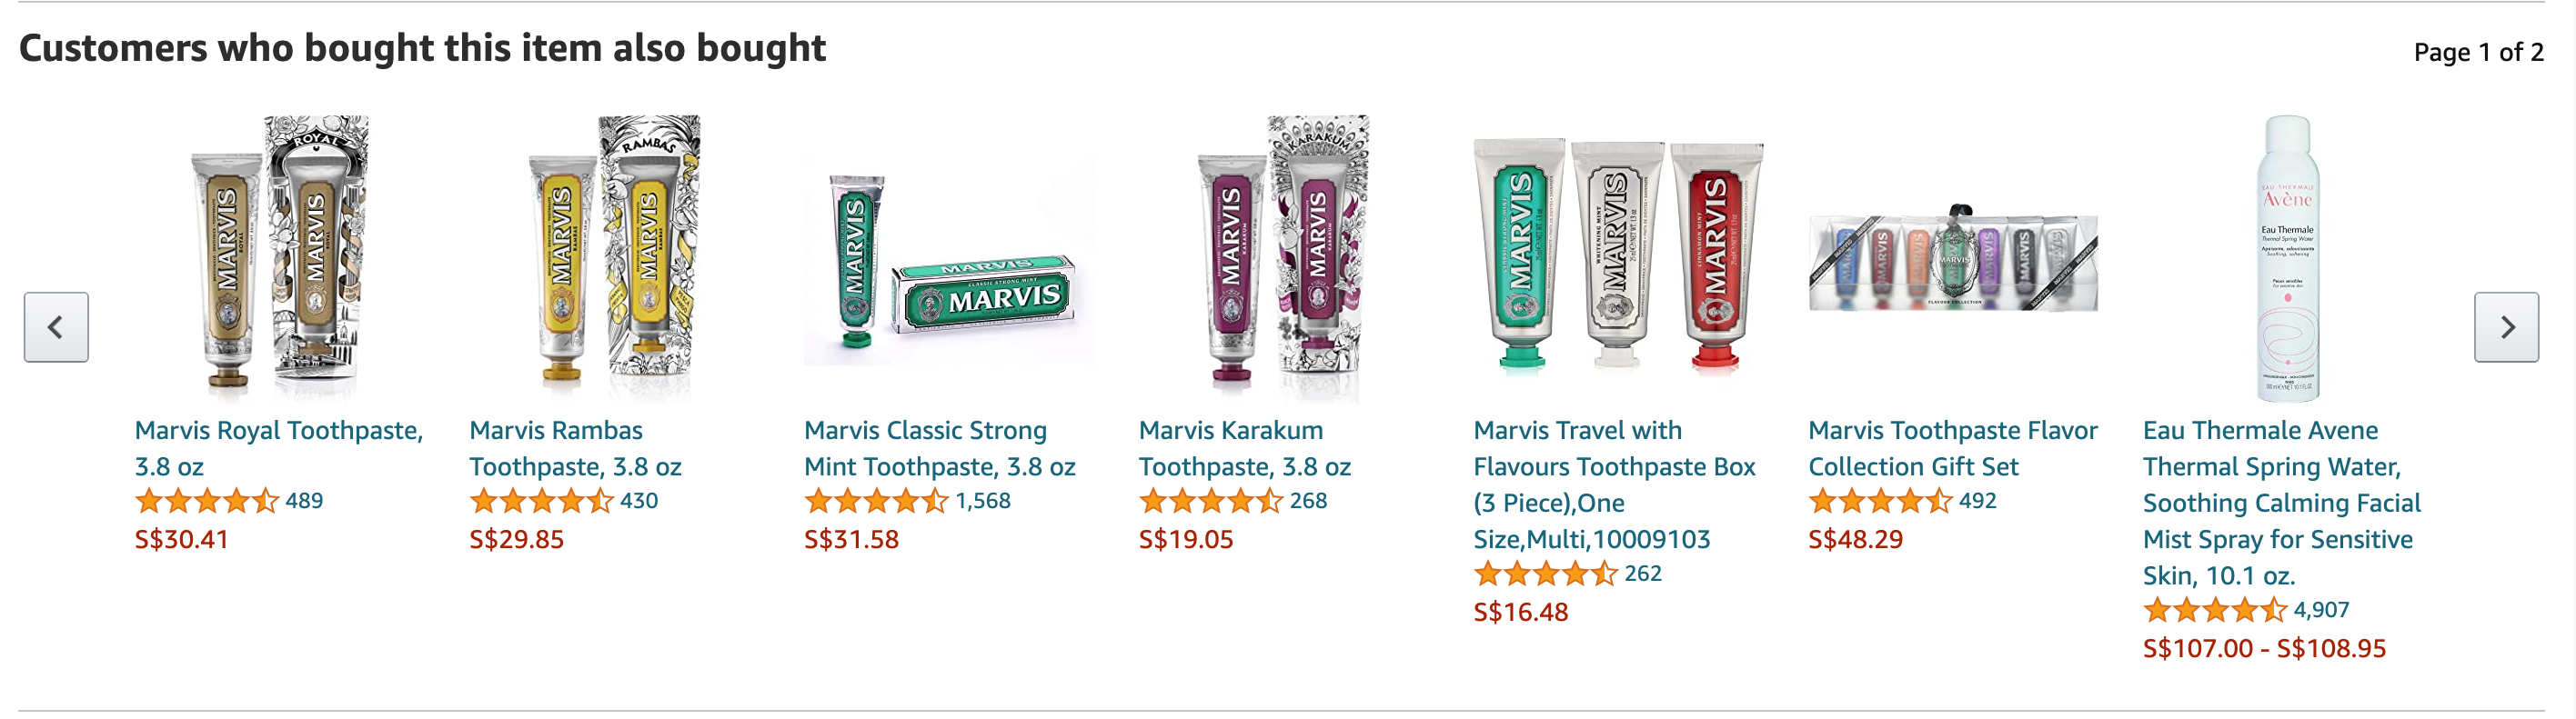

In [4]:
#Sample recommendation data from Amazon
from IPython.display import Image
Image(filename='/Users/rudharapathipandiyan/Desktop/my_dsi/dsi_roughpaper/project_capstone/Luxury Beauty/data/img/marvis_alsobought.png',width=800, height=400)

Here we only have to analyse the itemms and user's profile for recommendation which is makes it less cumbersome thus producing more reliable results with fewer users in the dataset. Items are recommended on a feature level basis and it avoids cold-start problem as new items can be suggested before being rated by a considerable number of users.

The problem is if the products doesn't contain enough information to differentiate the items accurately, the recommendations itself risks being imprecise. Sometimes the recommendations are overspecialized as the recommendations are done based using features that match up the user's profile with available items.

# Recommendation based on collaboration

Collaborative filtering doesn't need any amount of product informationa as opposed to Content based filtering except user's historical preference on a set of items. There are two implementations of Collaborative filtering. User-based CF is find users who have similar taste of products as the current user. User-X is similar to user-Y because both purchased items A,B and C. 
Item-based CF is recommend items similar to the items the user has bought. Items A and B were purchased by both users X and Y, therefore they are similar.

Here we use knn machine learning algorithm to find clusters of similar products based on common product ratings and make predictions using the average rating of top-k nearest neighbors. 

In [611]:
reviews=pd.read_csv('reviews_preprocessed_final.csv',dtype='unicode',usecols = ['reviewerID','product_id','ratings','reviewcomb','ratings','title','description','clean_description','year','polarity'])

In [612]:
reviews.shape

(462437, 9)

In [613]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462437 entries, 0 to 462436
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   reviewerID         462437 non-null  object
 1   product_id         462437 non-null  object
 2   ratings            462437 non-null  object
 3   title              462437 non-null  object
 4   description        462437 non-null  object
 5   year               462437 non-null  object
 6   reviewcomb         462437 non-null  object
 7   clean_description  462437 non-null  object
 8   polarity           462437 non-null  object
dtypes: object(9)
memory usage: 31.8+ MB


In [614]:
reviews.dropna(inplace=True)

In [615]:
reviews["ratings"] = reviews.ratings.astype(int)
reviews["year"] = reviews.year.astype(int)

In [587]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462451 entries, 0 to 464828
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   reviewerID         462451 non-null  object
 1   product_id         462451 non-null  object
 2   ratings            462451 non-null  int64 
 3   title              462451 non-null  object
 4   description        462451 non-null  object
 5   year               462451 non-null  int64 
 6   reviewcomb         462451 non-null  object
 7   clean_description  462451 non-null  object
dtypes: int64(2), object(6)
memory usage: 31.8+ MB


In [589]:
reviews.shape

(462451, 8)

In [590]:
product_rating_count = (reviews.groupby(by = ['title'])['ratings'].
                      count().
                      reset_index().
                      rename(columns = {'ratings':'total_rating_count'})
                      [['title','total_rating_count']])

product_rating_count.head()

,title,total_rating_count
0,"3LAB Perfect Balancing Toner, 5.3 oz",1
1,"3LAB WW Cream, 2 oz",3
2,"AGADIR Argan Oil Spray Treatment, 5.1 oz",1074
3,"AGADIR Argan Oil Treatment, 4 oz",8
4,AHAVA Dead Mineral Botanic Velvet Cream Body Washes,113


In [591]:
rating_with_total_rating_count = reviews.merge(product_rating_count, left_on='title', right_on = 'title',how = 'left')
rating_with_total_rating_count.head()

,reviewerID,product_id,ratings,title,description,year,reviewcomb,clean_description,total_rating_count
0,A11LNPG39A2ZV4,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz","['Marvis Jasmin Mint offers a sweet and cool touch of mint with the surprising charm of the floral note of jasmin. Marvis flavors are created by offsetting the aroma of mint, to provide the freshness you need, with innovative notes to offer you a long-lasting pleasurable taste sensation that can be different every day. Marvis is a luxury line of oral care products that turn your daily teeth cleaning ritual into a wonderful sensory experience. Our gentle xylitol- and sorbitan-based formulas cleanse and condition your teeth and gums without causing irritation.', 'By Marvis', '', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/a6ee37b8-8520-468e-8999-4cdb4825b4ce._SL220__.jpg"">', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/8ab0d41b-dbd4-48ac-84e7-1815d65028df._SL220__.jpg"">', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/1091a036-acfb-440a-a2e6-1e77c9a1166d._SL220__.jpg"">', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/c5b9a12a-6a27-4b8b-944a-81354d926705._SL220__.jpg"">']",2010,"I've been using&nbsp;<a data-hook=""product-link-linked"" class=""a-link-normal"" href=""/Marvis-Classic-Strong-Mint-Toothpaste/dp/B000J56ZZK/ref=cm_cr_arp_d_rvw_txt?ie=UTF8"">Marvis Classic Strong Mint Toothpaste</a>&nbsp;for more than a year now, and I really love what it does for my teeth and breath.\n\nAs a new treat, I decided to try the Jasmin Mint flavor...delicious! The Jasmin is very subtle, not too sweet or flowery, just a really beautiful complement to the mint. It would be nice for a man or a woman (anyone who thinks $10 is a reasonable price for an everyday luxury). The light periwinkle tube is almost as delicious as the flavor, and another subtle touch by Marvis. Mmmmm, as the old toothpaste commercials used to say! Love my Marvis!",marvi jasmin mint offer sweet cool touch mint surpris charm floral note jasmin marvi flavor creat offset aroma mint provid fresh need innov note offer long last pleasur tast sensat differ everi day marvi luxuri line oral care product turn daili teeth clean ritual wonder sensori experi gentl xylitol sorbitan base formula cleans condit teeth gum without caus irrit marvi,414
1,A1VUN4JU731CBH,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz","['Marvis Jasmin Mint offers a sweet and cool touch of mint with the surprising charm of the floral note of jasmin. Marvis flavors are created by offsetting the aroma of mint, to provide the freshness you need, with innovative notes to offer you a long-lasting pleasurable taste sensation that can be different every day. Marvis is a luxury line of oral care products that turn your daily teeth cleaning ritual into a wonderful sensory experience. Our gentle xylitol- and sorbitan-based formulas cleanse and condition your teeth and gums without causing irritation.', 'By Marvis', '', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/a6ee37b8-8520-468e-8999-4cdb4825b4ce._SL220__.jpg"">', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/8ab0d41b-dbd4-48ac-84e7-1815d65028df._SL220__.jpg"">', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/1091a036-acfb-440a-a2e6-1e77c9a1166d._SL220__.jpg"">', '<img alt="""" src=""https://m.media-amazon.com/images/S/aplus-media/vc/c5b9a12a-6a27-4b8b-944a-81354d926705._SL220__.jpg"">']",2010,"I had seen the Marvis toothpastes before and always wondered why in the world anyone would spend a whopping 10 dollars on a toothpaste. That was until recently when an order I had placed on the web included a tiny sample tube of the original&nbsp;<a data-hook=""product-link-linked"" class=""a-link-normal"" href=""/Marvis-Classic-Strong-Mint-Toothpaste/dp/B000J56ZZK/ref=cm_cr_arp_d_rvw_txt?ie=UTF8"">Marvis Classic Strong Mi

In [592]:
product_rating_count['total_rating_count'].describe()

count    11267.000000
mean        41.044732
std        136.786857
min          1.000000
25%          3.000000
50%         10.000000
75%         33.000000
max       4442.000000
Name: total_rating_count, dtype: float64

In [593]:
rating_with_total_rating_count = rating_with_total_rating_count[['reviewerID','product_id','ratings','title','total_rating_count','year']].copy()

In [594]:
rating_with_total_rating_count

,reviewerID,product_id,ratings,title,total_rating_count,year
0,A11LNPG39A2ZV4,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2010
1,A1VUN4JU731CBH,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2010
2,A2CBVSJ1OV2Q4S,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2009
3,A34XM0ECYBB4DH,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2008
4,A2PMRY7ADA8WJ2,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2008
...,...,...,...,...,...,...
462446,A2HPJMRRTYJ2M9,B01HIQCSBC,5,"CND Shellac, Brick Knit",6,2016
462447,A37M9GZV5PMABX,B01HIQCSBC,2,"CND Shellac, Brick Knit",6,2016
462448,A256VO0MCZSDGE,B01HIQCSBC,3,"CND Shellac, Brick Knit",6,2016
462449,A2VVJW6PY48A9M,B01HIQCSBC,5,"CND Shellac, Brick Knit",6,2016


In [595]:
#Filter only the popular items to reduce complexity
popularity_threshold = 100
rating_popular_product = rating_with_total_rating_count.query('total_rating_count >= @popularity_threshold')
rating_popular_product.head(5)

,reviewerID,product_id,ratings,title,total_rating_count,year
0,A11LNPG39A2ZV4,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2010
1,A1VUN4JU731CBH,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2010
2,A2CBVSJ1OV2Q4S,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2009
3,A34XM0ECYBB4DH,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2008
4,A2PMRY7ADA8WJ2,B00063M3EC,5,"Marvis Jasmin Mint Toothpaste, 3.8 oz",414,2008


In [596]:
rating_popular_product.shape

(286522, 6)

In [664]:
#create a pivot table for reviewers and products
product_features_df=rating_popular_product.pivot_table(index='title',columns='reviewerID',values='ratings').fillna(0)
product_features_df.head()

reviewerID,A0002708WFPIPQT73GK8,A0010876CNE3ILIM9HV0,A004163085WKABQBPDOX,A00429781HNBIV43ZMDH,A00603384WJS45MGZ9ZV,A0067293ETUPO6WG7DKU,A0070287EH1P1FHWO3GW,A00715535PBFELMZ5WXI,A0079565JVNZVYXB7V5Y,A0083151S7B2BNQPHPB9,...,AZZT1ERHBSNQ8,AZZU5BA2CHYVF,AZZUO98LB93B2,AZZWSTMUNPRP0,AZZXCFBNEWIBQ,AZZXN7LGEXW8S,AZZYMSP9YNZ5H,AZZYUA6JI1MO0,AZZYW4YOE1B6E,AZZZ3LGTCGUZF
title,,,,,,,,,,,,,,,,,,,,,
"AGADIR Argan Oil Spray Treatment, 5.1 oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHAVA Dead Mineral Botanic Velvet Cream Body Washes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clarisonic Refreshing Foaming Gel Cleanser 6 fl oz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"EltaMD intense Moisturizer, 2.8 oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [665]:
product_features_df.shape

(960, 253266)

We will use Nearest Neighbors with 'brute' and 'cosine' similarity to calculate the similarity between items.

In [691]:
#use sklearn's csr_matrix to craete a sparse matrix
product_features_df_matrix = csr_matrix(product_features_df.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(product_features_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [692]:
product_features_df.shape

(960, 253266)

In [693]:
query_index = np.random.choice(product_features_df.shape[0])
print(query_index)
query_index =300
distances, indices = model_knn.kneighbors(product_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)


601


In [694]:
product_features_df.head()

reviewerID,A0002708WFPIPQT73GK8,A0010876CNE3ILIM9HV0,A004163085WKABQBPDOX,A00429781HNBIV43ZMDH,A00603384WJS45MGZ9ZV,A0067293ETUPO6WG7DKU,A0070287EH1P1FHWO3GW,A00715535PBFELMZ5WXI,A0079565JVNZVYXB7V5Y,A0083151S7B2BNQPHPB9,...,AZZT1ERHBSNQ8,AZZU5BA2CHYVF,AZZUO98LB93B2,AZZWSTMUNPRP0,AZZXCFBNEWIBQ,AZZXN7LGEXW8S,AZZYMSP9YNZ5H,AZZYUA6JI1MO0,AZZYW4YOE1B6E,AZZZ3LGTCGUZF
title,,,,,,,,,,,,,,,,,,,,,
"AGADIR Argan Oil Spray Treatment, 5.1 oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHAVA Dead Mineral Botanic Velvet Cream Body Washes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Clarisonic Refreshing Foaming Gel Cleanser 6 fl oz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"EltaMD intense Moisturizer, 2.8 oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [695]:

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(product_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}'.format(i, product_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results:

1: HOT TOOLS Professional 1875W Ionic Anti-Static Dryer, with distance of 0.9889094712795498
2: Hot Tools Micro Crimper, 1 Inch, with distance of 0.9931934769643105
3: HOT TOOLS HOT TOOLS PINKTITANIUM Salon Titanium Curling Iron, with distance of 0.9945721534031682
4: Elchim Classic 2001 Dryer, with distance of 0.995011495332321
5: Hot Tools Professional Ceramic Titanium Professional Curling Iron, 1&quot;, with distance of 0.9954289734355057
6: HOT TOOLS Professional 24K Gold Marcel Iron/Wand for Long Lasting Results, with distance of 0.9958657594163735
7: Hot Tools Professional Nano Ceramic Tapered Curling Iron for Shiny Curls, Medium &frac12; to 1 Inch, with distance of 0.99598822127402
8: Oribe Dry Texturizing Spray for Unisex, 2.2 Ounce, with distance of 0.9960953820527081
9: Mason Pearson Detangler Hair Brush, with distance of 0.9961421545458136


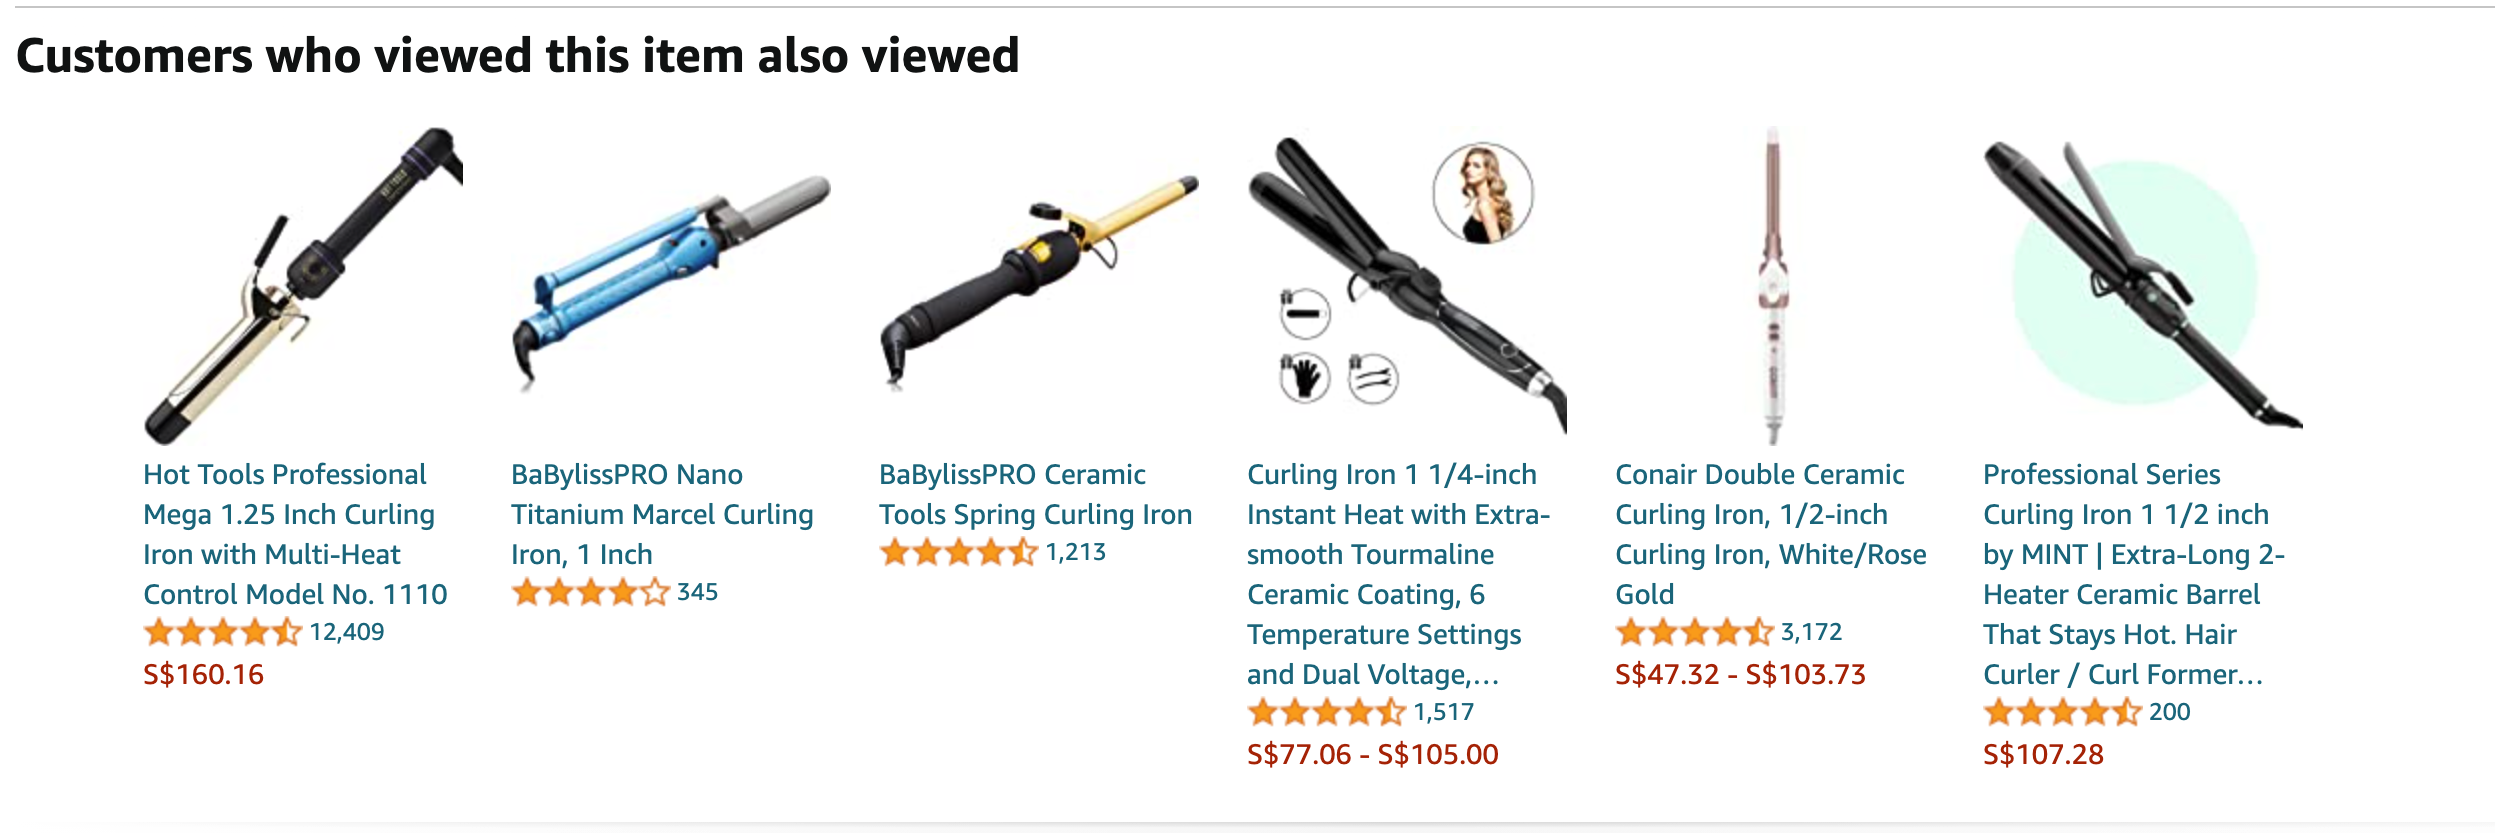

In [3]:
from IPython.display import Image
Image(filename='/Users/rudharapathipandiyan/Desktop/my_dsi/dsi_roughpaper/project_capstone/Luxury Beauty/data/img/hottools_alsoview.png',width=800, height=400)